In [22]:
# Import needed functions
from csv import reader
from math import sqrt
from math import e
from math import pi
from math import log

In [118]:
# Load csv file and retun as a list of list
def load_csv(filename):
	count = 0
	dataset = list()
	with open(filename, 'r', encoding="utf8") as file:
		csv_reader = reader(file)
		for row in csv_reader:
			# remove column names (Gender,Emotion_Joy,Emotion_Sadness,Emotion_Anger,Emotion_Disgust,Emotion_Fear,Emotion_Surprise,Emotion_Contempt,Emotion_Neutral,Depression)
			if count == 0:
				count = 1
				continue
			dataset.append(row)
	return dataset

def convert_categorical_to_numerical(dataset):
	'''
	Converts categorical value to numerical

	Parameters
	dataset (list) : list of list of dataset 

	Returns
	dataset (list) : list of list of dataset where categorical values are converted into numerical values
	'''
	for row in dataset:
		# Female->0, Male->1
		if row[0] == "Female":
			row[0] = 0
		else:
			row[0] = 1
		
		# No->0, Yes-> 1
		if row[-1] == "NO":
			row[-1] = 0
		else:
			row[-1] = 1
	return dataset

def convert_string_to_int(dataset):
	'''
	Converts string type to int type

	Parameters
	dataset (list) : list of list of dataset 

	Returns
	dataset (list) : list of list of dataset where all values are int type
	'''
	for row in dataset:
		for i in range(len(row)):
			# if value is int type, continue
			if isinstance(row[i], int):
				continue
			# else, cast value to int type
			else:
				try:
					row[i] = int(row[i])
				except ValueError:
					continue
	return dataset

def split_data_by_labels(dataset):
	'''
	Split the dataset by class labels

	Parameters
	dataset (list) : list of list of dataset (with labels)
	
	Returns
	labels_list (list) : list of distinct labels in the dataset
		eg: [0, 1] 
		- there are two different labels found in the dataset

	seperated_dataset (list) : list of list of seperated dataset
		eg: [[[0, 4, 3, 2],[0, 8, 0, 2],[1, 6, 2, 3]], [[1, 3, 2, 1],[0, 6, 3, 2],[0, 6, 1, 0]]] 
		- a list with length of 2 is returned where each element corresponds to the row value of the respective labels
	'''
	labels_list = []
	seperated_dataset = []

	for row in dataset:
		# get the label value of the row, assume that the label value is always the last column of the dataset
		label_value = row[-1]
		# check if label value has been stored into labels_list
		if label_value not in labels_list:
			# append new label value to labels_list
			labels_list.append(label_value)
			# append new empty list to seperated_dataset and add the row data into the new list
			seperated_dataset.append([])
			seperated_dataset[-1].append(row[:-1])
		else:
			# get index of corresponding label value
			index = labels_list.index(row[-1])
			# append the row to seperated_dataset of the index 
			seperated_dataset[index].append(row[:-1])

	return labels_list, seperated_dataset

def calculate_mean(list_numbers):
	'''
	Calculate the mean value from a list of numbers

	Parameters
	list_numbers (list) : list of numbers 

	Returns
	mean (float) : mean value
	'''
	sum = 0
	# loop through list of numbers and add them up
	for num in list_numbers:
		sum += num
	# divide the sum by the total list_numbers count
	mean = sum / len(list_numbers)
	return mean
 
def calculate_standard_deviation(numbers):
	'''
	Calculate the standard deviation from a list of numbers

	Parameters
	numbers (list) : list of numbers

	Returns
	standard_deviation (float) : standard deviation value
	'''
	# calculate the mean
	mean = calculate_mean(numbers)
	sum_square_difference = 0
	# loop through the list of numbers and add up the squared differences 
	for num in numbers:
		sum_square_difference += (num - mean) ** 2
	# clculate variance 
	variance = sum_square_difference / (len(numbers) - 1)
	# clculate standard deviation 
	standard_deviation = sqrt(variance)
	return standard_deviation

def calculate_details(seperated_dataset):
	'''
	Calculate mean, standard deviation & count by columns seperated by labels

	Parementers
	seperated_dataset (list) : list of list of dataset that was seperated by labels

	Returns
	value_result (list) : [mean, std_dev] list of list of mean & standard deviation calculated for each column by each labels
		eg: [[[0.66, 0.47, 4],[8.72, 10.72, 4],[2.29, 3.35, 4], [[0.56, 0.50, 5],[9.12, 11.96, 5],[3.67, 3.35, 5]]]
	'''
	value_result = []
	# labels_list, seperated_dataset = split_data_by_labels(dataset) TODO: remove
	for j in range(len(seperated_dataset)):
		x_list = []
		count = 0
		for row in seperated_dataset[j]:
			for i in range(len(row)):
				if count == 0:
					x_list.append([])
					x_list[-1].append(row[i])
				else:
					x_list[i].append(row[i])
			count = 1

		count2 = 0
		for x_s in x_list:
			if count2 == 0:
				value_result.append([])
				count2 = 1
			value_result[-1].append([calculate_mean(x_s), calculate_standard_deviation(x_s), len(seperated_dataset[j])])
	return value_result

def calculate_gaussian_probability(x, mean, std_dev):
	'''
	Calculate Gaussian Probability of x

	Parameters
	x (int) : column value x
	mean (float) : mean value of the column of x for a specific label
	std_dev (float) : standard deviation value of the column of x for a specific label

	Returns
	gaussian_probability (float) : Gaussian Probability of x
	'''
	lhs = 1 / (std_dev * sqrt(2 * pi))
	exponent = -(1 / 2) * ((x - mean) / std_dev) ** 2 
	gaussian_probability = lhs * (e ** exponent) 
	return gaussian_probability

def calculate_probabilities_by_class(row, labels_list, dataset_details, use_log):
	'''
	Calculate Probability of a row for each labels

	Parameters
	row (list) : list of a row of data
	labels_list (list) : list containing all possible labels for the dataset
	dataset_details (list) : [mean, std_dev] list of list of mean & standard deviation for each column seperated by labels
	use_log (boolean) : True if perfom log operation on Gaussian Probability, else False

	Returns
	probabilities_list (list) : list of probabilities for each labels
	'''
	probabilities_list = []
	for i in range(len(labels_list)):
		try:
			if use_log:
				lsss = "up"
				# probability = log(dataset_details[i][0][-1] / sum([dataset_details[k][0][-1] for k in range(len(dataset_details))]))
				probability = (dataset_details[i][0][-1] / sum([dataset_details[k][0][-1] for k in range(len(dataset_details))]))
			else:
				probability = dataset_details[i][0][-1] / sum([dataset_details[k][0][-1] for k in range(len(dataset_details))]) 

			for j in range(len(row)):
				if (use_log):
					lsss = "down"
					temp1 = calculate_gaussian_probability(row[j], dataset_details[i][j][0], dataset_details[i][j][1])
					temp2 = (row[j], dataset_details[i][j][0], dataset_details[i][j][1], dataset_details[i][j][2])
					if temp1 != 0:
						probability *= log(calculate_gaussian_probability(row[j], dataset_details[i][j][0], dataset_details[i][j][1]))
				else:
					probability *= calculate_gaussian_probability(row[j], dataset_details[i][j][0], dataset_details[i][j][1])
		except Exception as e:
			print(e)
			print(temp1)
			print(temp2)
			print(lsss)
			print("error")
			print(probability)

		# if use_log:
		# 	probability = log(dataset_details[i][0][-1] / sum([dataset_details[k][0][-1] for k in range(len(dataset_details))]))
		# else:
		# 	probability = dataset_details[i][0][-1] / sum([dataset_details[k][0][-1] for k in range(len(dataset_details))]) 

		# for j in range(len(row)):
		# 	if (use_log):
		# 		probability *= log(calculate_gaussian_probability(row[j], dataset_details[i][j][0], dataset_details[i][j][1]))
		# 	else:
		# 		probability *= calculate_gaussian_probability(row[j], dataset_details[i][j][0], dataset_details[i][j][1])

		probabilities_list.append(probability)

	return probabilities_list

def predict(row, labels_list, dataset_details, use_log):
	'''
	Predict the label for a given row.
	
	Parameters
	row (list) : list of a row of data
	labels_list (list) : list containing all possible labels for the dataset
	dataset_details (list) : [mean, std_dev] list of list of mean & standard deviation for each column seperated by labels
	use_log (boolean) : True if perfom log operation on Gaussian Probability, else False

	Returns 
	predicted_label (int) : the integer value representing the label with the highest probability
	'''
	probabilities_list = calculate_probabilities_by_class(row, labels_list, dataset_details, use_log)
	prediction = -9999999
	predicted_label = -1
	# loop through probability calculated for each label
	for i in range(len(probabilities_list)):
		# get the label with the highest probability value
		if probabilities_list[i] > prediction:
			prediction = probabilities_list[i]
			predicted_label = labels_list[i]
	return predicted_label

def predict_all(dataset_without_labels, labels_list, dataset_details, use_log=False):
	''' 
	Predict all labels for dataset using Naive Bayes classification algorithm.

	Parameters
	dataset_without_labels (list) : list of list of dataset
	labels_list (list) : list containing all possible labels for the dataset
	dataset_details (list) : [mean, std_dev] list of list of mean & standard deviation for each column seperated by labels
	use_log (boolean) : True if perfom log operation on Gaussian Probability, else False

	Returns
	predicted_labels (list) : the list of predicted labels
	'''
	predicted_labels = []
	for row in dataset_without_labels:
		predicted_label = predict(row, labels_list, dataset_details, use_log)
		predicted_labels.append(predicted_label)
	return predicted_labels

def calculate_accuracy(predicted_labels, actual_labels):
	'''
	Calculate the accuracy based on the predicted labels

	Parameters
	predicted_labels (list) : list of predicted labels
	actual_labels (list) : list of actual labels

	Returns
	accuracy (int) : the accuracy
	'''
	correct_count = 0
	# loop through predicted and actual labels
	for predicted, actual in zip(predicted_labels, actual_labels):
		# if predicted label equals the actual label
		if predicted == actual:
			correct_count += 1
	# calculate accuracy
	accuracy = correct_count / len(predicted_labels)
	return accuracy

def zeroR(dataset, labels_list):
	'''
	Predict all labels for dataset using ZeroR classification algorithm.

	Parameters
	dataset (list) : list of list of dataset
	labels_list (list) : list containing all possible labels for the dataset

	Returns
	predicted_labels (list) : the list of predicted labels
	'''
	# initialize a list of 0 that has the same length as all possible labels to store total count of each labels in the dataset
	label_count_list = [0] * len(labels_list)

	#loop through each row in the dataset
	for row in dataset:
		# loop through each label in the labels_list
		for i in range(len(labels_list)):
			# check if the actual label of the row is equal to the label of the labels_list
			if row[-1] == labels_list[i]:
				# add the count of the label in the label_count_list
				label_count_list[i] +=1

	# loop through the label_count_list to find the most frequent label in the dataset
	most_frequent_label = -1
	most_frequent_label_count = -1
	for i in range(len(label_count_list)):
		# if the count of current label is greater than the highest label count
		if label_count_list[i] > most_frequent_label_count:
			most_frequent_label_count = label_count_list[i]
			# set highest label count as the current label
			most_frequent_label = labels_list[i]

	predicted_labels = [most_frequent_label] * len(dataset)
	return predicted_labels

def build_frequency_table(column_value_list, labels):
	''' 
	Count the frequency of each label for each column value

	Parameters
	column_value_list (list) : list of data of the same column
	labels (list) : list of actual labels of the dataset

	Returns
	frequency_table (dict of dict) : dictionary with column value as key and frequency count of each lables 
		eg: {2: {0: 5, 1: 9}, 0: {0: 27, 1: 21}, 5: {1: 1}}
	'''
	# Count the frequency of each class label for each feature value
	frequency_table = {}
	for feature_value, label in zip(column_value_list, labels):
		if feature_value not in frequency_table:
			frequency_table[feature_value] = {}
		if label not in frequency_table[feature_value]:
			frequency_table[feature_value][label] = 0
		frequency_table[feature_value][label] += 1

	return frequency_table

def calculate_error(column_value_list, labels):
	"""
	Calculate the error rate for a given feature and label pair.

	Parameters
	column_value_list (list) : A list of feature values.
	labels (list) : A list of corresponding class labels.
		
	Returns
	error_rate (float) : The error rate for this feature.
	"""

	frequency_table = build_frequency_table(column_value_list, labels)
	# # Count the frequency of each class label for each feature value
	# frequency_table = {}
	# for feature_value, label in zip(column_value_list, labels):
	# 	if feature_value not in frequency_table:
	# 		frequency_table[feature_value] = {}
	# 	if label not in frequency_table[feature_value]:
	# 		frequency_table[feature_value][label] = 0
	# 	frequency_table[feature_value][label] += 1

	# Calculate the total number of samples
	total_samples = len(column_value_list)
	total_errors = 0
	# loop through each column value 
	for feature_value, label_counts in frequency_table.items():
		# label_counts is the inner dictoray for the occurence frequency for each labels
		# get the label with higest count for this column
		higest_count_label = max(label_counts, key=label_counts.get)
		error_count = sum(label_counts.values()) - label_counts[higest_count_label]
		total_errors += error_count

    # Return the error rate
	error_rate = total_errors / total_samples
	return error_rate

def oneR_predict(column_value, best_predictor_frequency_table):
	'''
	return predicted label based on the best predictor

	Parameters
	column_value (int) : a single predictor value of a column
	best_predictor_frequency_table (dict) : dictionary with column value as key and frequency count of each lables of the best predictor

	Returns
	predicted_label (int) : predicted label
	'''
	column_value_dict = best_predictor_frequency_table[column_value]
	predicted_label = max(column_value_dict, key=column_value_dict.get)

	return predicted_label

def OneR_classification(dataset_without_labels, train_labels):
	"""
	Implements the OneR classification algorithm, which selects a single feature to make predictions.

	Parameters
	train_features (list of lists) : A list of training samples, where each sample is a list of feature values.
	train_labels (list) : A list of labels from the training set.
		
	Returns
	predicted_labels (list) : the list of predicted labels
	"""
	# Find the best feature by calculating the error rate for each feature
	best_predictor_index = None
	lowest_error_rate = 9999
	# loop though each column
	for column_index in range(len(dataset_without_labels[0])):
		# get a list of all values in a column
		column_values = [row[column_index] for row in dataset_without_labels]
		error_rate = calculate_error(column_values, train_labels)
		# get the lowest error rate 
		if error_rate < lowest_error_rate:
			best_predictor_index = column_index
			lowest_error_rate = error_rate

	# get the column values of the best predictor
	best_predictor_column_values = [row[best_predictor_index] for row in dataset_without_labels]
	# get the frequency table of the best predictor
	best_predictor_frequency_table =  build_frequency_table(best_predictor_column_values, train_labels)

	# predict the labels by using the best predictor
	predicted_labels = []
	for column_value in best_predictor_column_values:
		predicted_label = oneR_predict(column_value, best_predictor_frequency_table)
		predicted_labels.append(predicted_label)

	return predicted_labels

def z_score_normalization(dataset_without_labels):
	'''
	normalize dataset with z-score normalization

	Parameters
	dataset_without_labels (list) : list of list of dataset without labels

	Returns
	normalized_dataset (list) : list of list of normalized dataset
	'''
	normalized_dataset = []
	first_value = True
	for column_index in range(len(dataset_without_labels[0])):
		# get a list of all values in a column
		column_values = [row[column_index] for row in dataset_without_labels]
		mean = calculate_mean(column_values)
		std_dev = calculate_standard_deviation(column_values)
		# normalize the values of a column
		normalized_column_values = [(x - mean) / std_dev for x in column_values]

		for i in range(len(normalized_column_values)):
			if first_value:
				normalized_dataset.append([])
			normalized_dataset[i].append(normalized_column_values[i])
		
		first_value = False
	
	return normalized_dataset

Accuracy of Naive Bayes Algorithm:  0.58
Accuracy of ZeroR Algorithm:  0.52
Accuracy of OneR Algorithm:  0.68

--------------------------------------------------------------------------------------------------------------------------------

Improving the Naive Bayes Classification Algoritm

Using Z-score Normalization
----------------------------------------------------------------
Accuracy of Naive Bayes Algorithm with Z-Score Normalized Dataset:  0.54

Using Log Probabilities
----------------------------------------------------------------
Accuracy of Naive Bayes Algorithm with Log Probabilities:  0.59
Explaination:
The accuracy of the naive bayes model has increased with the use of Log Probabilities.
As probabilites are very small numbers, the multiplication of probabilites will result in very small numbers which may be reduce the precision of the values.
Thus, with log proabbility, the problem is overcomed as multiplication of logs results in addition of the values.

Using Feature 

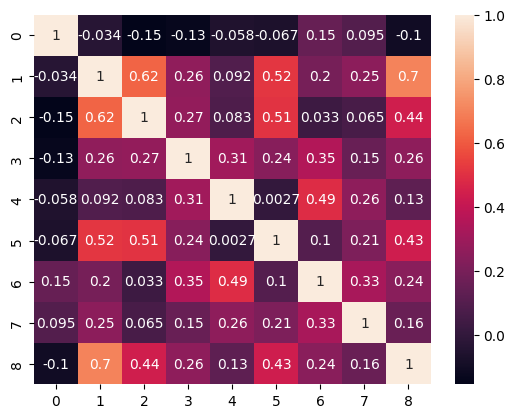

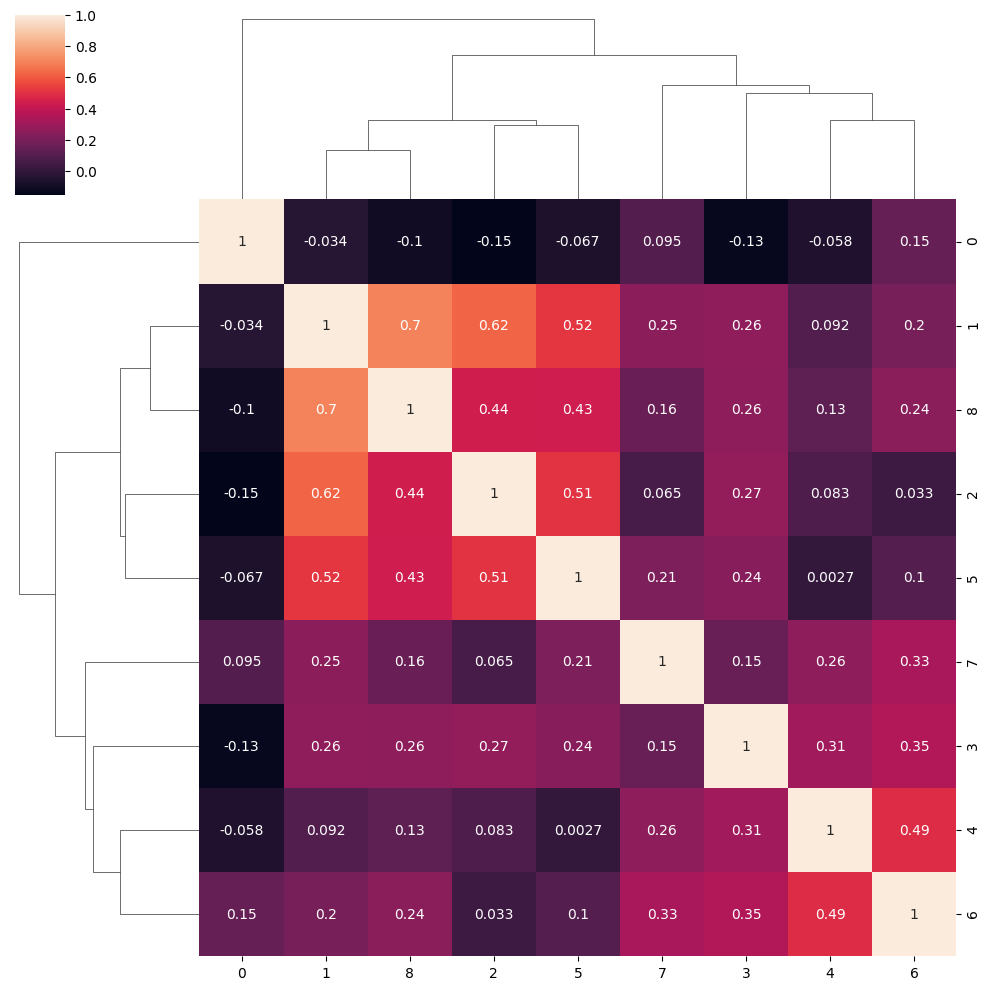

In [128]:
'''preprocess the dataset'''
dataset_string = "dataset.csv"
# load the dataset
dataset = load_csv(dataset_string)
# convert the dataset with categorical value to numerical value
dataset = convert_categorical_to_numerical(dataset)
# convert string value to integer value
dataset = convert_string_to_int(dataset)
# split the dataset by labels
labels_list, seperated_dataset = split_data_by_labels(dataset)
# calculate the dataset details which are mean, standard deviation and number of occurence for the label
dataset_details = calculate_details(seperated_dataset)

# get dataset without the labels
dataset_without_labels = [row[:-1] for row in dataset]
# get a list of actual labels of the dataset
actual_labels = [row[-1] for row in dataset]

'''predicting the dataset'''
# predict one row of data only
predicted_label = predict(dataset[0][:-1], labels_list, dataset_details, False)
# predict the labels with Naive Bayes classification algorithm
predicted_labels_naive_bayes = predict_all(dataset_without_labels, labels_list, dataset_details)
# predict the labels with ZeroR classification algorithm
predicted_labels_zeroR = zeroR(dataset, labels_list)
# predict the labels with OneR classification algorithm
predicted_labels_oneR = OneR_classification(dataset_without_labels, actual_labels)

''' validate performance of the model'''
# calculate accuracy of each classification algorithm
accuracy_naive_bayes = calculate_accuracy(predicted_labels_naive_bayes, actual_labels)
accuracy_zeroR = calculate_accuracy(predicted_labels_zeroR, actual_labels)
accuracy_oneR = calculate_accuracy(predicted_labels_oneR, actual_labels)

print("Accuracy of Naive Bayes Algorithm: ", accuracy_naive_bayes)
print("Accuracy of ZeroR Algorithm: ", accuracy_zeroR)
print("Accuracy of OneR Algorithm: ", accuracy_oneR)

print()
print("--------------------------------------------------------------------------------------------------------------------------------")
print()
print("Improving the Naive Bayes Classification Algoritm")
print()

# perform z-score Normalization on the dataset
print("Using Z-score Normalization")
print("----------------------------------------------------------------")
# perform z-score normalization on the dataset
dataset_without_labels_zScore_normalized = z_score_normalization(dataset_without_labels)

dataset_with_labels_zScore_normalized = []
for i in range(len(dataset_without_labels_zScore_normalized)):
    temp_row = dataset_without_labels_zScore_normalized[i].copy()
    temp_row.append(actual_labels[i])
    dataset_with_labels_zScore_normalized.append(temp_row)

labels_list, seperated_dataset_zScore_normalized = split_data_by_labels(dataset_with_labels_zScore_normalized)
dataset_details_zScore_normalized = calculate_details(seperated_dataset_zScore_normalized)

# predict the labels with Naive Bayes classification algorithm on normalized dataset
predicted_labels_naive_bayes_zScore_normalized = predict_all(dataset_without_labels_zScore_normalized, labels_list, dataset_details_zScore_normalized, True)
accuracy_naive_bayes_zScore_normalized = calculate_accuracy(predicted_labels_naive_bayes_zScore_normalized, actual_labels)
print("Accuracy of Naive Bayes Algorithm with Z-Score Normalized Dataset: ", accuracy_naive_bayes_zScore_normalized)
print()

# predict the labels with Naive Bayes classification algorithm with Log Probabilities
print("Using Log Probabilities")
print("----------------------------------------------------------------")
predicted_labels_naive_bayes_log = predict_all(dataset_without_labels, labels_list, dataset_details, True)
accuracy_naive_bayes_log = calculate_accuracy(predicted_labels_naive_bayes_log, actual_labels)
print("Accuracy of Naive Bayes Algorithm with Log Probabilities: ", accuracy_naive_bayes_log)
print("Explaination:")
print("The accuracy of the naive bayes model has increased with the use of Log Probabilities.")
print("As probabilites are very small numbers, the multiplication of probabilites will result in very small numbers which may be reduce the precision of the values.")
print("Thus, with log proabbility, the problem is overcomed as multiplication of logs results in addition of the values.")

'''Find and Remove correlated features'''
import seaborn as sns
from pandas import DataFrame
df = DataFrame(dataset_without_labels)

print()
print("Using Feature Selection Method by removing Correlated features")
print("----------------------------------------------------------------")
# calculate the correlations
correlations = df.corr()
# plot the heatmap 
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True)
# plot the clustermap 
sns.clustermap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True)
print("From the heat map, we can see that feature 1 and feature 8 has very high total corelation score")
print("feature 1 (Emotion_Joy): \t-0.034+0.7+0.62+0.52+0.25+0.26+0.092+0.2 = 2.608")
print("feature 8 (Emotion_Neutral): \t-0.1+0.7+0.44+0.43+0.16+0.26+0.13+0.24 = 2.26")
print("Removing highly corelated features may help in improving the model performance as it may lead to double counting of the importance of the features.")

# remove corelated features
dataset = load_csv(dataset_string)
dataset = convert_categorical_to_numerical(dataset)
dataset = convert_string_to_int(dataset)

# remove column 1
for row in dataset:
    del row[1:2] 

# remove column 8
for row in dataset:
    del row[7:8]

labels_list, seperated_dataset = split_data_by_labels(dataset)
dataset_details = calculate_details(seperated_dataset)
# get dataset without the labels
dataset_without_labels_dropJoy = [row[:-1] for row in dataset]
# get a list of actual labels of the dataset
actual_labels = [row[-1] for row in dataset]

# predict the labels with Naive Bayes classification algorithm
predicted_labels_naive_bayes_dropJoy = predict_all(dataset_without_labels_dropJoy, labels_list, dataset_details)

# calculate accuracy of each classification algorithm
accuracy_naive_bayes_dropJoy = calculate_accuracy(predicted_labels_naive_bayes_dropJoy, actual_labels)
print("Accuracy of Naive Bayes Algorithm with Emotion_Joy and Emotion_Neutral removed: ", accuracy_naive_bayes_dropJoy)

                  0             1             2             3             4  \
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean   5.107026e-17  1.332268e-17  5.662137e-17 -2.609024e-17  1.110223e-17   
std    1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00   
min   -1.250641e+00 -7.038259e-01 -8.879906e-01 -1.017522e+00 -8.090398e-01   
25%   -1.250641e+00 -4.375613e-01 -5.929771e-01 -6.871580e-01 -8.090398e-01   
50%    7.995901e-01 -2.600517e-01 -2.979636e-01 -1.365506e-01 -1.348400e-01   
75%    7.995901e-01  6.212839e-03  2.920634e-01  3.039353e-01  5.393599e-01   
max    7.995901e-01  6.840335e+00  5.602306e+00  2.506365e+00  4.584559e+00   

                  5             6             7             8  
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  
mean   2.220446e-17  2.664535e-17  9.547918e-17  1.942890e-17  
std    1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00  
min   -7.443845e-01 -1.041327e+0

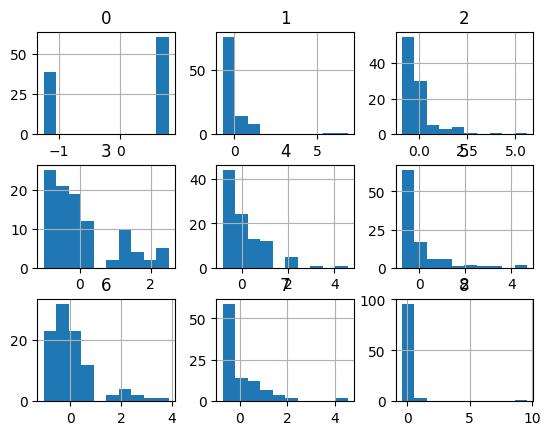

0.58
                  0             1             2             3             4  \
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean   5.107026e-17  1.332268e-17  5.662137e-17 -2.609024e-17  1.110223e-17   
std    1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00  1.005038e+00   
min   -1.250641e+00 -7.038259e-01 -8.879906e-01 -1.017522e+00 -8.090398e-01   
25%   -1.250641e+00 -4.375613e-01 -5.929771e-01 -6.871580e-01 -8.090398e-01   
50%    7.995901e-01 -2.600517e-01 -2.979636e-01 -1.365506e-01 -1.348400e-01   
75%    7.995901e-01  6.212839e-03  2.920634e-01  3.039353e-01  5.393599e-01   
max    7.995901e-01  6.840335e+00  5.602306e+00  2.506365e+00  4.584559e+00   

                  5             6             7             8           9  
count  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean   2.220446e-17  2.664535e-17  9.547918e-17  1.942890e-17    0.520000  
std    1.005038e+00  1.005038e+00  1.005038e+00  1.0050

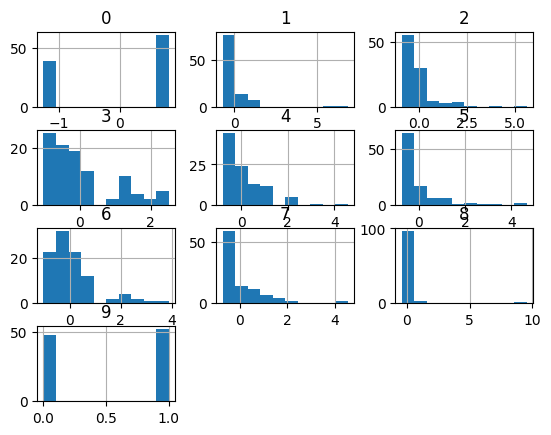

In [123]:
from sklearn.preprocessing import StandardScaler

dataset = load_csv("dataset.csv")
dataset = convert_categorical_to_numerical(dataset)
dataset = convert_string_to_int(dataset)
dataset_without_labels = [row[:-1] for row in dataset]
# get a list of actual labels of the dataset
actual_labels = [row[-1] for row in dataset]

# create an instance of the StandardScaler class
scaler = StandardScaler()

# fit the scaler to the data and transform it
dataset_without_labels_scaled = scaler.fit_transform(dataset_without_labels)
dataset_without_labels_scaled = dataset_without_labels_scaled.tolist()

from pandas import DataFrame
from matplotlib import pyplot
aa = DataFrame(dataset_without_labels_scaled)
# summarize
print(aa.describe())
# histograms of the variables
aa.hist()
pyplot.show()

dataset_with_labels_scaled = []
for i in range(len(dataset_without_labels_scaled)):
    temp_row = dataset_without_labels_scaled[i].copy()
    temp_row.append(actual_labels[i])
    dataset_with_labels_scaled.append(temp_row)

labels_list, seperated_dataset_scaled = split_data_by_labels(dataset_with_labels_scaled)
dataset_details_scaled = calculate_details(seperated_dataset_scaled)

# predict the labels with Naive Bayes classification algorithm
predicted_labels_naive_bayes_scaled = predict_all(dataset_without_labels_scaled, labels_list, dataset_details_scaled)
# calculate accuracy of each classification algorithm
accuracy_naive_bayes_scaled = calculate_accuracy(predicted_labels_naive_bayes_scaled, actual_labels)
print(accuracy_naive_bayes_scaled)

from pandas import DataFrame
from matplotlib import pyplot
dataset = DataFrame(dataset_with_labels_scaled)
# summarize
print(dataset.describe())
# histograms of the variables
dataset.hist()
pyplot.show()

In [127]:
print(dataset_without_labels_zScore_normalized)
print()
print(dataset_without_labels_scaled)

[[-1.2443719453851159, -0.4353680408725132, -0.0029353471649516526, -0.13586615880534705, -0.1341640786499874, -0.740653197100815, 0.19005515334271444, 0.16186162065652648, -0.36429412784010845], [-1.2443719453851159, -0.08212825111793857, -0.8835394966504662, -0.13586615880534705, -0.8049844718999245, -0.49540379408730006, -1.036107126287701, -0.7130660585679408, -0.2004436955282156], [0.7955820634429429, -0.34705809343386956, -0.8835394966504662, -1.0124220220656504, -0.8049844718999245, 2.6928384450883938, 0.19005515334271444, -0.7130660585679408, 0.4003412229487249], [0.7955820634429429, -0.17043819855658224, -0.8835394966504662, 0.30241177282480464, -0.8049844718999245, -0.740653197100815, 2.029298572788338, -0.7130660585679408, -0.4189109386107394], [0.7955820634429429, -0.5236779883111569, -0.2964700636601232, -0.5741440904354987, -0.8049844718999245, -0.2501543910737852, -0.42302598647249334, -0.7130660585679408, -0.09121007398695369], [-1.2443719453851159, 1.2425209604617162, 

In [126]:
print(dataset_details_zScore_normalized)
print()
print(dataset_details_scaled)

[[[0.11559739383358995, 0.9718199474988036, 48], [-0.017735581110594232, 0.9467101862602901, 48], [-0.21085577134903155, 0.9837692203519938, 48], [-0.19065090025911602, 0.8841000117796586, 48], [-0.23199205266560327, 0.7450635414855998, 48], [-0.14796713981815393, 0.8279542522280171, 48], [-0.12925794031103957, 0.7795003062568707, 48], [-0.12066710909304111, 0.9655865700545222, 48], [-0.1344483825137032, 0.23416033683085158, 48]], [[-0.10670528661562163, 1.0230492312645243, 52], [0.01637130564054856, 1.05576601899368, 52], [0.19463609662987527, 0.9842813369374469, 52], [0.1759854463930301, 1.0747373465935797, 52], [0.21414651015286446, 1.1542024336824772, 52], [0.13658505213983446, 1.1268566604351504, 52], [0.11931502182557496, 1.1623133154990142, 52], [0.1113850237781918, 1.0274196708046077, 52], [0.12410619924341834, 1.3630585003771971, 52]]]

[[[0.11617975214817, 0.9767157968595194, 48], [-0.017824929691744186, 0.9514795372826833, 48], [-0.21191802377142666, 0.9887252679418264, 48],

In [124]:
predicted_labels_naive_bayes_scaled

[0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

In [147]:
from sklearn.preprocessing import MinMaxScaler

dataset = load_csv("dataset.csv")
dataset = convert_categorical_to_numerical(dataset)
dataset = convert_string_to_int(dataset)
dataset_without_labels = [row[:-1] for row in dataset]
# get a list of actual labels of the dataset
actual_labels = [row[-1] for row in dataset]

# create an instance of the StandardScaler class
scaler = MinMaxScaler()

# fit the scaler to the data and transform it
dataset_without_labels_scaled = scaler.fit_transform(dataset_without_labels)
dataset_without_labels_scaled = dataset_without_labels_scaled.tolist()

dataset_with_labels_scaled = []
for i in range(len(dataset_without_labels_scaled)):
    temp_row = dataset_without_labels_scaled[i].copy()
    temp_row.append(actual_labels[i])
    dataset_with_labels_scaled.append(temp_row)

labels_list, seperated_dataset_scaled = split_data_by_labels(dataset_with_labels_scaled)
dataset_details_scaled = calculate_details(seperated_dataset_scaled)

# predict the labels with Naive Bayes classification algorithm
predicted_labels_naive_bayes_scaled = predict_all(dataset_without_labels_scaled, labels_list, dataset_details_scaled)
# calculate accuracy of each classification algorithm
accuracy_naive_bayes_scaled = calculate_accuracy(predicted_labels_naive_bayes_scaled, actual_labels)
print(accuracy_naive_bayes_scaled)

0.58


In [151]:
print(dataset_details_scaled)
print(dataset_details)

[[[0.6666666666666666, 0.47639306734033077, 48], [0.09093137254901956, 0.12612131724931921, 48], [0.10416666666666667, 0.15233899171176235, 48], [0.234375, 0.252151645102029, 48], [0.10677083333333333, 0.13883439385987795, 48], [0.10984848484848485, 0.15345311234094494, 48], [0.18489583333333334, 0.15893090156301007, 48], [0.1128472222222222, 0.1839364542126907, 48], [0.028617216117216113, 0.02355676282006951, 48]], [[0.5576923076923077, 0.5015060275070906, 52], [0.09547511312217191, 0.1406498028172087, 52], [0.16695804195804193, 0.1524182941768658, 52], [0.3389423076923077, 0.30652277614006007, 52], [0.18990384615384615, 0.21507292512580922, 52], [0.16258741258741263, 0.20885171039410946, 52], [0.23557692307692307, 0.23698195067812577, 52], [0.15705128205128208, 0.19571516122629867, 52], [0.054628064243448855, 0.13712504106303772, 52]]]
[[[0.6666666666666666, 0.47639306734033077, 48], [8.729166666666666, 10.720311966192133, 48], [2.2916666666666665, 3.3514578176587717, 48], [1.875, 2.

In [144]:
dataset_details_scaled

[[[0.6666666666666666, 0.47639306734033077, 48],
  [0.09093137254901956, 0.12612131724931921, 48],
  [0.10416666666666667, 0.15233899171176235, 48],
  [0.234375, 0.252151645102029, 48],
  [0.10677083333333333, 0.13883439385987795, 48],
  [0.10984848484848485, 0.15345311234094494, 48],
  [0.18489583333333334, 0.15893090156301007, 48],
  [0.1128472222222222, 0.1839364542126907, 48],
  [0.028617216117216113, 0.02355676282006951, 48]],
 [[0.5576923076923077, 0.5015060275070906, 52],
  [0.09547511312217191, 0.1406498028172087, 52],
  [0.16695804195804193, 0.1524182941768658, 52],
  [0.3389423076923077, 0.30652277614006007, 52],
  [0.18990384615384615, 0.21507292512580922, 52],
  [0.16258741258741263, 0.20885171039410946, 52],
  [0.23557692307692307, 0.23698195067812577, 52],
  [0.15705128205128208, 0.19571516122629867, 52],
  [0.054628064243448855, 0.13712504106303772, 52]]]

In [ ]:
import numpy as np

# create a numpy array
arr = np.array([1, 2, 3, 4, 5])

# convert to a list
lst = arr.tolist()

print(lst)  # Output: [1, 2, 3, 4, 5]


In [125]:
# Using the copy() method
old_list = [1, 2, 3]
new_list = old_list.copy()
new_list.append(4)

print(old_list)  # Output: [1, 2, 3]
print(new_list)  # Output: [1, 2, 3, 4]

[1, 2, 3]
[1, 2, 3, 4]


In [89]:
column_value_list = [1, 2, 3, 2,2]
labels = [0,1,0,0, 1]
frequency_table = {}
for feature_value, label in zip(column_value_list, labels):
    if feature_value not in frequency_table:
        frequency_table[feature_value] = {}
    if label not in frequency_table[feature_value]:
        frequency_table[feature_value][label] = 0
    frequency_table[feature_value][label] += 1

print(frequency_table)
# most_common_label = max(label_counts, key=label_counts.get)
# print(most_common_label)


{1: {0: 1}, 2: {1: 2, 0: 1}, 3: {0: 1}}


In [100]:
my_dict = {"apple": 2, "banana": 3, "orange": 3}

max_key = max(my_dict, key=my_dict.get)

print(max_key)   # Output: "orange"


banana


In [87]:
max_key

'c'

In [58]:

# Test calculating class probabilities
dataset = [[3.393533211,2.331273381,0],
	[3.110073483,1.781539638,0],
	[1.343808831,3.368360954,0],
	[3.582294042,4.67917911,0],
	[2.280362439,2.866990263,0],
	[7.423436942,4.696522875,1],
	[5.745051997,3.533989803,1],
	[9.172168622,2.511101045,1],
	[7.792783481,3.424088941,1],
	[7.939820817,0.791637231,1]]
# dataset = convert_categorical_to_numerical(dataset)
# dataset = convert_string_to_int(dataset)
labels_list, seperated_dataset = split_data_by_labels(dataset)
dataset_details = calculate_details(seperated_dataset)
print(dataset_details)
predicted_label = predict(dataset[0][:-1], labels_list, dataset_details, False)
# use dataset[:-1] to pass in dataset without the labels
dataset_without_labels = [row[:-1] for row in dataset]
actual_labels = [row[-1] for row in dataset]
predicted_labels = predict_all(dataset_without_labels, labels_list, dataset_details)
predicted_labels_zeroR = zeroR(dataset, labels_list)

oneR_result = OneR_classification(dataset_without_labels, actual_labels)
print(oneR_result)

[[[2.7420144012, 0.9265683289298018, 5], [3.0054686692, 1.1073295894898725, 5]], [[7.6146523718, 1.2344321550313704, 5], [2.9914679790000003, 1.4541931384601618, 5]]]
label_count_list:  [5, 5]
most_frequent_label:  0
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [60]:
calculate_accuracy(predicted_labels_zeroR, actual_labels)

0.5

In [57]:
actual_labels

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

In [6]:
dataset[0][:-1],[0,1]

([3.393533211, 2.331273381], [0, 1])

In [7]:
dataset_details

[[[2.85742739175, 1.0275719447560472, 4],
  [3.04008827075, 1.275505774560249, 4]],
 [[6.725604049666667, 2.441618256572654, 6],
  [2.9707216929999998, 1.3016622439989782, 6]]]

In [56]:
sum([dataset_details[k][0][-1] for k in range(len(dataset_details))])

10

In [10]:
type(labels_list[0])

int

In [60]:
dataset

[[0, 4, 3, 2, 1, 0, 2, 2, 1, 0],
 [0, 8, 0, 2, 0, 1, 0, 0, 4, 0],
 [1, 5, 0, 0, 0, 14, 2, 0, 15, 0],
 [1, 7, 0, 3, 0, 0, 5, 0, 0, 0],
 [1, 3, 2, 1, 0, 2, 1, 0, 6, 1],
 [0, 23, 1, 1, 0, 0, 1, 1, 3, 0],
 [0, 6, 3, 2, 1, 1, 1, 1, 3, 1],
 [1, 6, 0, 2, 0, 1, 1, 0, 5, 0],
 [0, 1, 7, 3, 0, 7, 1, 0, 2, 1],
 [1, 3, 2, 2, 1, 0, 2, 2, 8, 1],
 [1, 6, 0, 3, 0, 2, 1, 2, 4, 1],
 [1, 6, 0, 1, 3, 4, 2, 7, 3, 0],
 [1, 6, 0, 1, 0, 0, 0, 3, 6, 0],
 [0, 3, 1, 0, 0, 1, 2, 3, 4, 0],
 [0, 7, 3, 5, 0, 1, 1, 0, 3, 0],
 [1, 11, 2, 0, 0, 16, 1, 1, 12, 1],
 [1, 6, 0, 0, 2, 0, 1, 0, 8, 1],
 [1, 19, 5, 8, 0, 7, 1, 0, 20, 1],
 [1, 3, 0, 1, 1, 0, 3, 0, 10, 0],
 [1, 1, 3, 1, 3, 1, 2, 2, 2, 0],
 [1, 3, 2, 1, 1, 1, 4, 1, 1, 0],
 [1, 4, 2, 1, 1, 1, 1, 1, 4, 1],
 [1, 9, 1, 3, 0, 2, 1, 4, 2, 1],
 [0, 5, 3, 5, 2, 1, 2, 1, 0, 1],
 [1, 7, 2, 1, 2, 1, 2, 0, 2, 1],
 [0, 9, 0, 0, 0, 0, 1, 4, 1, 0],
 [1, 6, 2, 5, 1, 3, 3, 1, 10, 1],
 [1, 18, 2, 6, 2, 4, 5, 2, 9, 0],
 [1, 25, 4, 2, 0, 7, 2, 0, 17, 0],
 [1, 10, 12, 0, 0, 2, 2, 0, 11

In [48]:
dataset_details

[[[0.6666666666666666, 0.47639306734033077, 48],
  [8.729166666666666, 10.720311966192133, 48],
  [2.2916666666666665, 3.3514578176587717, 48],
  [1.875, 2.017213160816232, 48],
  [0.8541666666666666, 1.1106751508790236, 48],
  [2.4166666666666665, 3.3759684715007894, 48],
  [1.4791666666666667, 1.2714472125040805, 48],
  [1.3541666666666667, 2.2072374505522894, 48],
  [5.208333333333333, 4.287330833252652, 48]],
 [[0.5576923076923077, 0.5015060275070906, 52],
  [9.115384615384615, 11.95523323946274, 52],
  [3.673076923076923, 3.353202471891047, 52],
  [2.7115384615384617, 2.4521822091204806, 52],
  [1.5192307692307692, 1.7205834010064738, 52],
  [3.576923076923077, 4.594737628670407, 52],
  [1.8846153846153846, 1.8958556054250062, 52],
  [1.8846153846153846, 2.3485819347155843, 52],
  [9.942307692307692, 24.956757473472866, 52]]]

In [51]:
dataset_details[1][0][-1] 

52

In [10]:
seperated_dataset

[[[0, 4, 3, 2, 1, 0, 2, 2, 1],
  [0, 8, 0, 2, 0, 1, 0, 0, 4],
  [1, 5, 0, 0, 0, 14, 2, 0, 15],
  [1, 7, 0, 3, 0, 0, 5, 0, 0],
  [0, 23, 1, 1, 0, 0, 1, 1, 3],
  [1, 6, 0, 2, 0, 1, 1, 0, 5],
  [1, 6, 0, 1, 3, 4, 2, 7, 3],
  [1, 6, 0, 1, 0, 0, 0, 3, 6],
  [0, 3, 1, 0, 0, 1, 2, 3, 4],
  [0, 7, 3, 5, 0, 1, 1, 0, 3],
  [1, 3, 0, 1, 1, 0, 3, 0, 10],
  [1, 1, 3, 1, 3, 1, 2, 2, 2],
  [1, 3, 2, 1, 1, 1, 4, 1, 1],
  [0, 9, 0, 0, 0, 0, 1, 4, 1],
  [1, 18, 2, 6, 2, 4, 5, 2, 9],
  [1, 25, 4, 2, 0, 7, 2, 0, 17],
  [0, 8, 0, 3, 0, 0, 1, 0, 3],
  [1, 26, 0, 0, 0, 13, 0, 11, 4],
  [1, 4, 3, 5, 0, 2, 0, 0, 5],
  [1, 6, 1, 0, 0, 0, 1, 0, 7],
  [1, 3, 2, 0, 1, 6, 1, 1, 1],
  [1, 2, 2, 3, 2, 0, 3, 0, 3],
  [0, 10, 3, 0, 0, 6, 3, 0, 2],
  [1, 1, 4, 0, 0, 0, 0, 0, 17],
  [1, 11, 1, 3, 2, 3, 1, 0, 4],
  [1, 6, 1, 2, 0, 3, 1, 0, 4],
  [1, 3, 4, 2, 2, 1, 3, 2, 2],
  [0, 5, 1, 0, 3, 2, 0, 0, 5],
  [1, 8, 4, 4, 0, 2, 1, 0, 3],
  [1, 9, 5, 7, 0, 2, 0, 0, 10],
  [0, 6, 2, 8, 4, 8, 1, 0, 4],
  [1, 10, 3, 2, 0, 2, 2, 